In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import skimage.restoration
import harmonica as hm
import verde as vd
import magali as mg


In [2]:
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 10

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

amplitude=abs(np.random.normal(0, 100, size))*1.0E-14

dipole_moments = hm.magnetic_angles_to_vec(directions_inclination, directions_declination, amplitude)

print(len(directions_inclination), len(directions_declination), len(amplitude))

10 10 10


In [3]:
dipole_coordinates = (
    np.random.randint(30, 1970, size), # µm
    np.random.randint(30, 1970, size), # µm
    np.random.randint(-20, -1, size) # µm
)

print(len(dipole_coordinates[0]))

10


In [4]:
sensor_sample_distance = 5.0e-6  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [ ]:
MICROMETER_TO_METER = 1e-6

def convet_micrometer_to_meter(coordinates):
    """
    Convert coordinates from micrometers to meters.

    Parameters:
    coordinates (tuple of float): A tuple containing coordinate values in micrometers.

    Returns:
    tuple of float: A tuple containing coordinate values converted to meters.
    """

    return tuple(c*MICROMETER_TO_METER for c in coordinates)

print(convet_micrometer_to_meter(dipole_coordinates))

print(convet_micrometer_to_meter(coordinates))

(array([1.039e-03, 8.450e-04, 1.609e-03, 9.940e-04, 1.015e-03, 8.030e-04,
       3.150e-04, 1.833e-03, 7.300e-05, 6.810e-04]), array([0.001711, 0.001118, 0.001896, 0.001832, 0.001257, 0.000648,
       0.000239, 0.001022, 0.000478, 0.000538]), array([-6.0e-06, -5.0e-06, -9.0e-06, -5.0e-06, -3.0e-06, -1.4e-05,
       -1.1e-05, -3.0e-06, -1.6e-05, -9.0e-06]))
(array([[0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       ...,
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03],
       [0.000e+00, 2.000e-06, 4.000e-06, ..., 1.996e-03, 1.998e-03,
        2.000e-03]]), array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.

In [6]:
def dipole_bz(coordinates, dipole_coordinates, dipole_moments):
    coordinates_m = convet_micrometer_to_meter(coordinates)
    dipole_coordinates_m = convet_micrometer_to_meter(dipole_coordinates)
    return hm.dipole_magnetic(coordinates_m, dipole_coordinates_m, dipole_moments, field="b_u")



In [7]:
def dipole_bz_grid(coordinates, dipole_coordinates, dipole_moments):
    bz = dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
    data.x.attrs = {"units": "µm"}
    data.y.attrs = {"units": "µm"}
    data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    return data

In [8]:
data = dipole_bz_grid(coordinates, dipole_coordinates, dipole_moments)
data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5e-06 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
Data variables:
    bz       (y, x) float64 8MB 5.032e+13 5.072e+13 ... 4.206e+13 4.154e+13

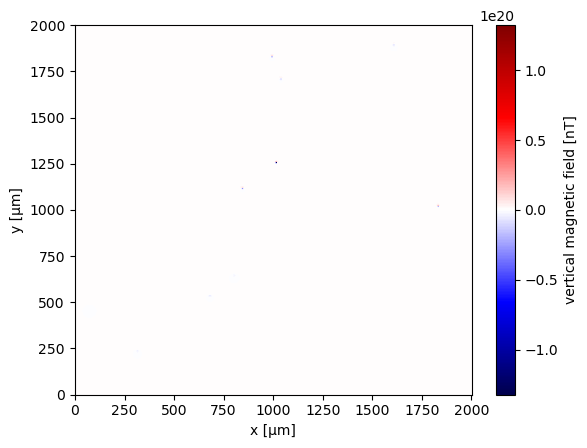

In [9]:
data.bz.plot.pcolormesh(cmap="seismic")

# Make a model like Souza-Junior's

In [10]:

sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [11]:
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude=abs(np.random.normal(0, 100, size))*1.0E-14



### Add 3 shallow sources

In [12]:
dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

In [13]:
data = dipole_bz_grid(coordinates, dipole_coordinates, dipole_moments)
data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB 2.041 2.051 2.061 2.071 ... 25.74 25.4 25.06

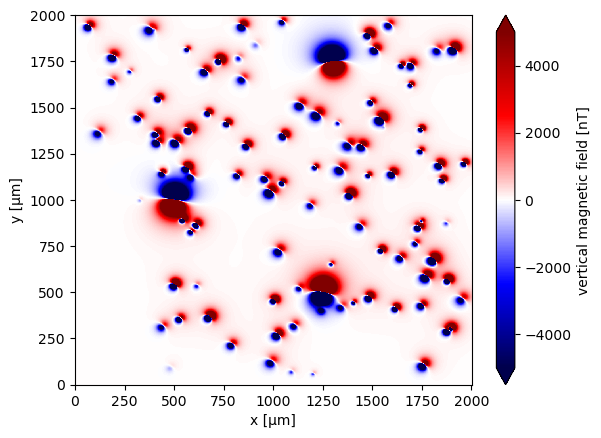

In [14]:
data.bz.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

# Souza-Junior's method

In [15]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [16]:
sources1 = 70
sources2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([np.random.normal(0, 10, sources1),np.random.normal(0, 10, sources2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sources1),np.random.normal(180, 10, sources2), [10, 170, 190]]),
    intensity=np.concatenate([abs(np.random.normal(0, 100, sources1+sources2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)

(array([ 897,  236, 1755, 1028, 1172, 1454,  103, 1062,  770, 1797,  441,
        654,  700, 1774, 1573,  234, 1965, 1167, 1491, 1134,   57, 1098,
        235, 1769, 1119, 1485, 1596, 1140, 1691,  176, 1308,  407, 1703,
       1416,   71, 1500, 1951,  240,  133, 1198, 1004,   35, 1880,  798,
        930, 1164,  706, 1927, 1745,  569,  829,  800,  354,  324, 1159,
        177,  304,  911,  275, 1189,  898,  394, 1675, 1724,  220, 1833,
       1545,  865, 1434, 1503,  213,  417,  633,  108,  831,  759,  883,
        421,  558, 1148,   44, 1016, 1853,  295, 1604, 1869,  174, 1443,
        448,  715, 1753,  438, 1451,  404, 1289,  774,   61, 1086,  362,
       1226, 1250, 1300,  500]), array([1955,  428,  205,  124,  880,  926, 1189, 1268,  558, 1118,  294,
       1528,   74,  668,  707,  124, 1513,  931,  775,  948,  210,  867,
       1776, 1754, 1913, 1083,  246,  662,  255,  506,  749, 1892,  577,
        909,  306,  207,  541,  614, 1726, 1264, 1067, 1274,  537,  781,
       1200, 1362

In [17]:
data = dipole_bz_grid(coordinates, dipole_coordinates, dipole_moments)
data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB -4.643 -4.693 -4.744 ... -0.02257 -0.04858

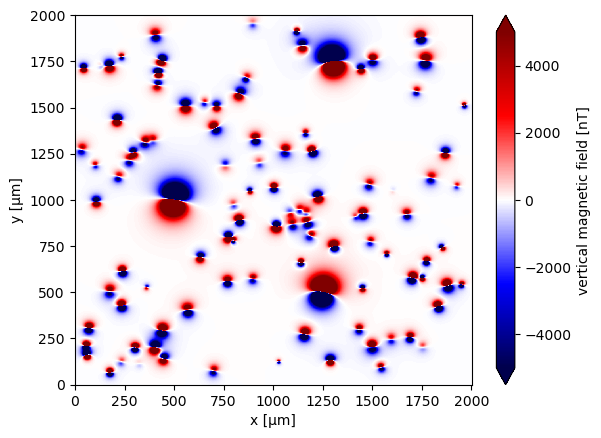

In [18]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)